# Food Detection

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
os.listdir('../Data/meta')

['classes.txt',
 'train.txt',
 'test.json',
 'labels.txt',
 'train.json',
 'test.txt']

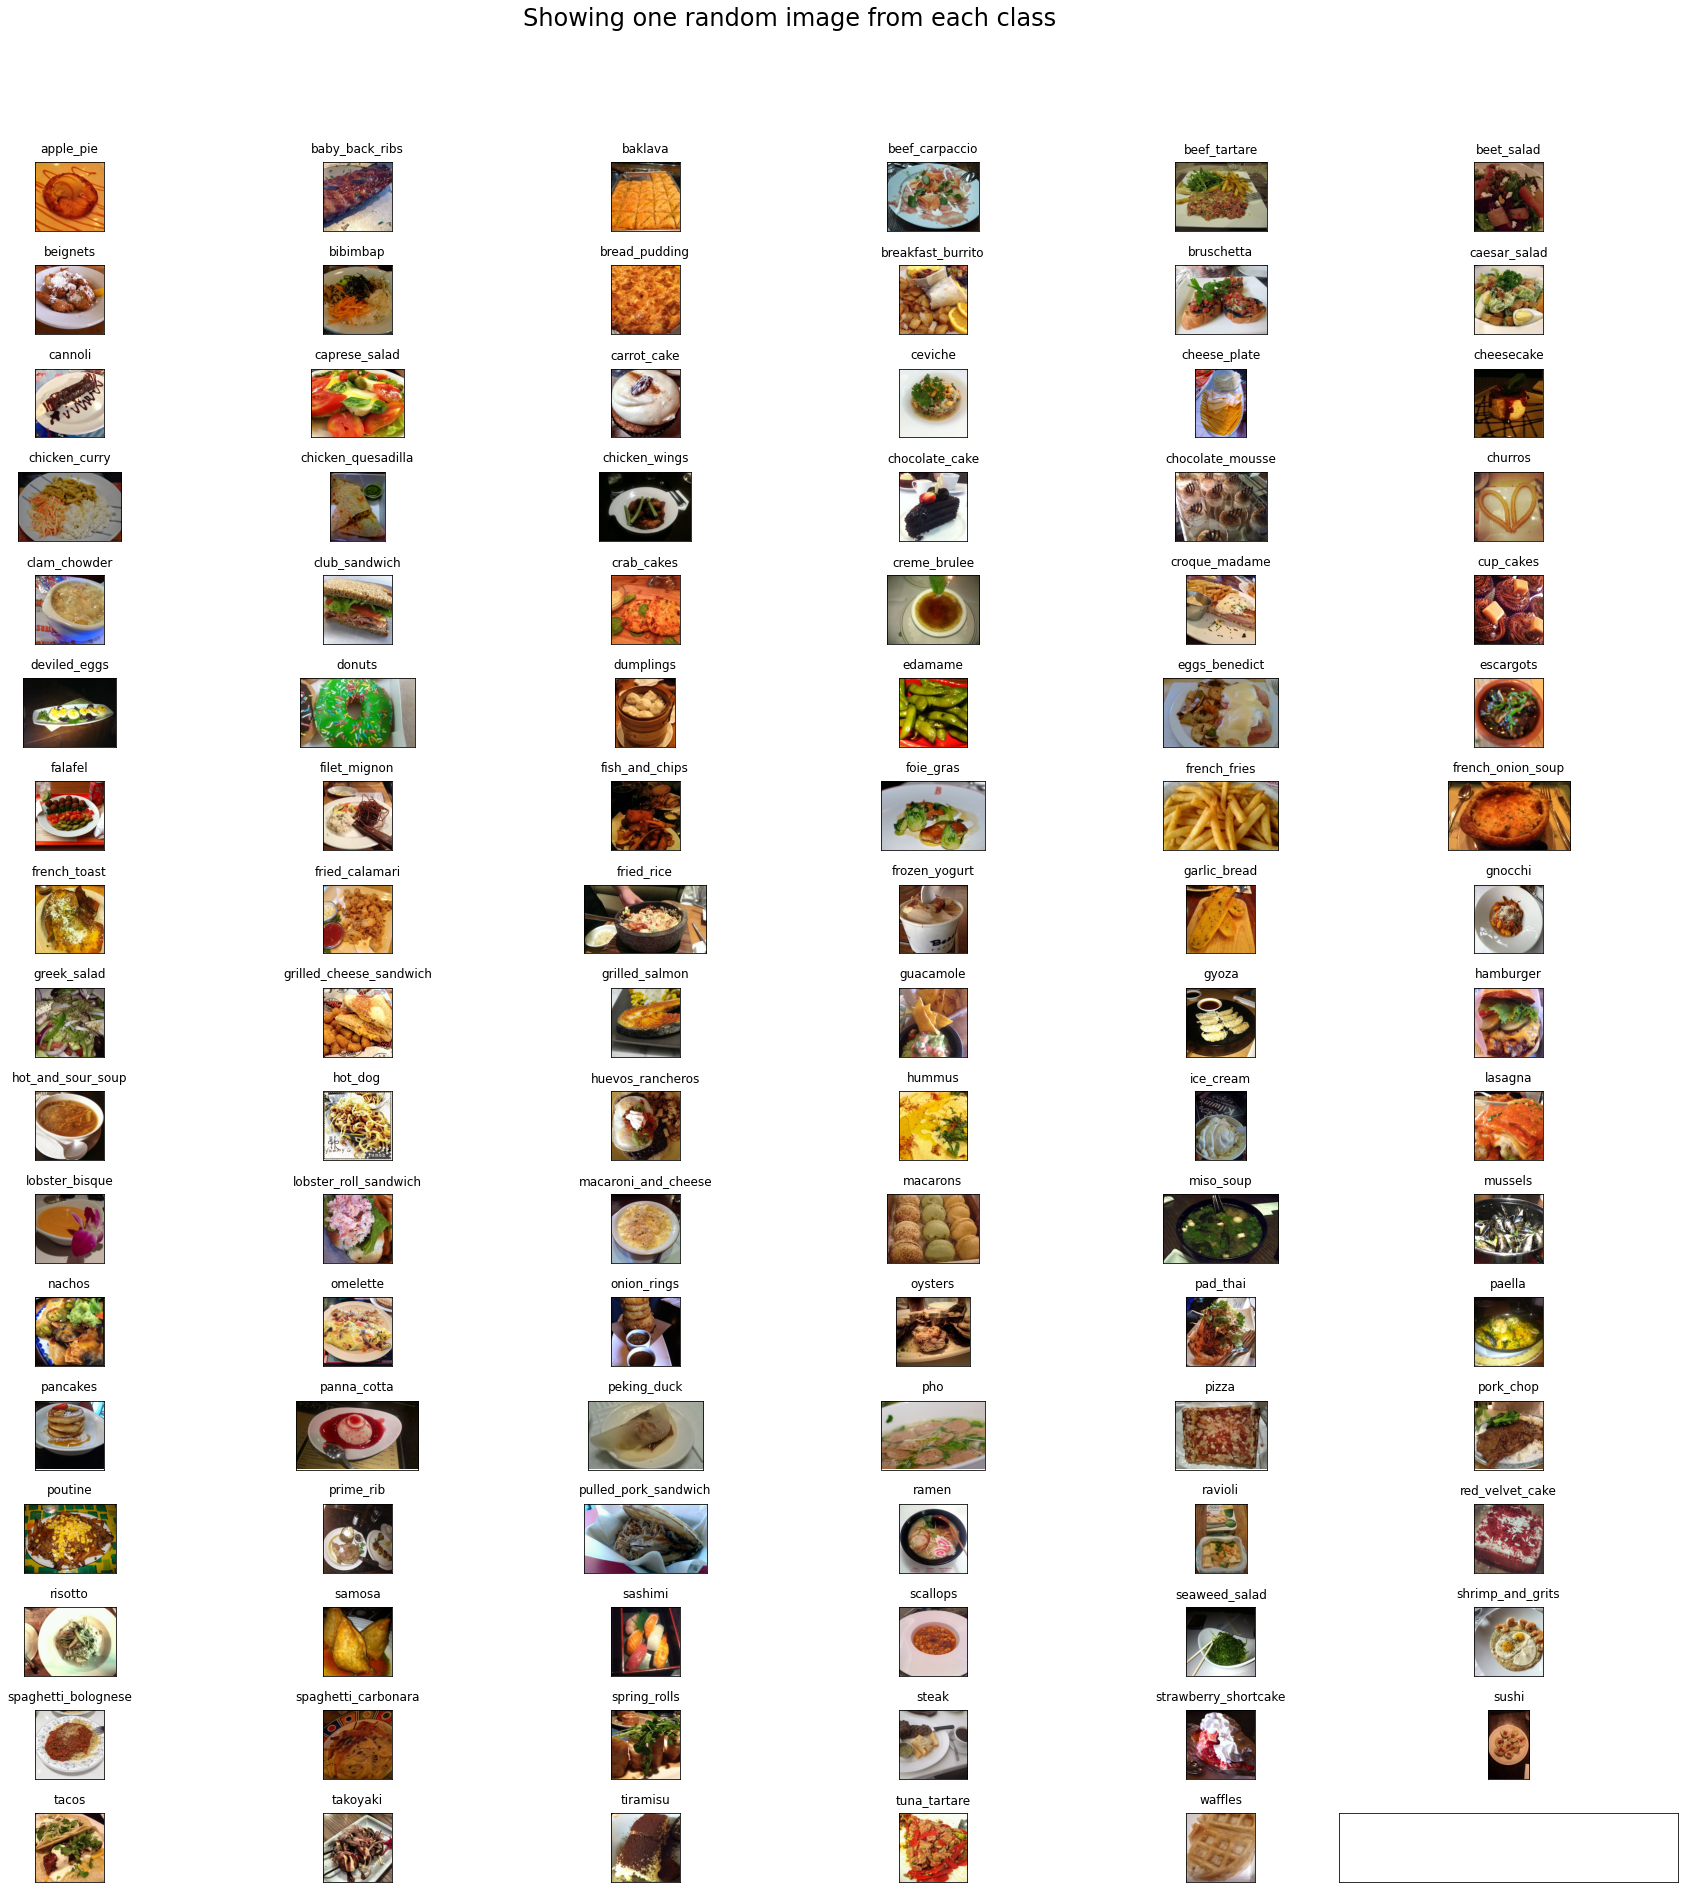

In [3]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "../data/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id]
            food_id += 1
        except:
            break
        if food_selected == '.DS_Store':
            continue
        food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
        food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
        img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

Splitting all the test and train data

In [4]:
from collections import defaultdict
from shutil import copy


def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")
print("Creating training data set\n")
prepare_data("../Data/meta/train.txt","../Data/images","../Data/Train")
print("Creating test dataset\n")
prepare_data("../Data/meta/test.txt","../Data/images","../Data/Test")

Creating training data set


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copyi

In [5]:
labels_file = open("../Data/labels.txt","r")
labels = [(line.strip()).replace(" ","_") for line in labels_file]
# print(labels)
file_count=0
for x in labels:
    # print(x)
    path_fol=os.path.join("../Data/Test",x)
    # print(path_fol)
    path, dirs, files = next(os.walk(path_fol))
    file_count += len(files)
    # print(x,":",file_count)
print(file_count)

25250


In [6]:
labels_file = open("../Data/labels.txt","r")
labels = [(line.strip()).replace(" ","_") for line in labels_file]
# print(labels)
file_count=0
for x in labels:
    # print(x)
    path_fol=os.path.join("../Data/Train",x)
    # print(path_fol)
    path, dirs, files = next(os.walk(path_fol))
    file_count += len(files)
    # print(x,":",file_count)
print(file_count)

75750


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

K.clear_session()
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = '../Data/Train'
validation_data_dir = '../Data/Test'
nb_train_samples = 75750 #2250
nb_validation_samples = 25250 #750
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')
spe=nb_train_samples // batch_size
vs=nb_validation_samples // batch_size
history = model.fit(train_generator,
                      steps_per_epoch = spe,
                      validation_data=validation_generator,
                      validation_steps=vs,
                      epochs=30,
                      verbose=1,
                      callbacks=[csv_logger, checkpointer])
# model.save('model_trained_3class.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Metal device set to: Apple M1


2021-09-25 15:55:26.876917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-25 15:55:26.877004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/data-science/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-09-25 15:55:28.077253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-25 15:55:28.077431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to 

Epoch 1/30


2021-09-25 15:55:29.347398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2789/4734 [================>.............] - ETA: 27:17 - loss: 5.0254 - accuracy: 0.0472